In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import regex as re
import numpy as np

from read_1t1r_data import read_1t1r_data

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# plt.style.use('ggplot')

# print(plt.style.available)

In [3]:
folder = '.'

test_types = ['Form']
all_data = {}
for ttype in test_types:
    # recursively search the folder for excel files starting with ttype
    t, d, l = read_1t1r_data(folder, ttype)

    # sort the data by temerature and store it
    all_data[ttype] = sorted(list(zip(t,d)), key=lambda x:x[0])
    
    print(f"Found {len(d)} {ttype} Tests across {len(np.unique(t))} temperatures")

Found 30 Form Tests across 1 temperatures


In [4]:
# all_data['Form'][0]

The Form Operation has been tested on 26 devices
Form Voltage:
	mean: 1.670975076923077 Volts
	std: 0.4024783626654236 Volts


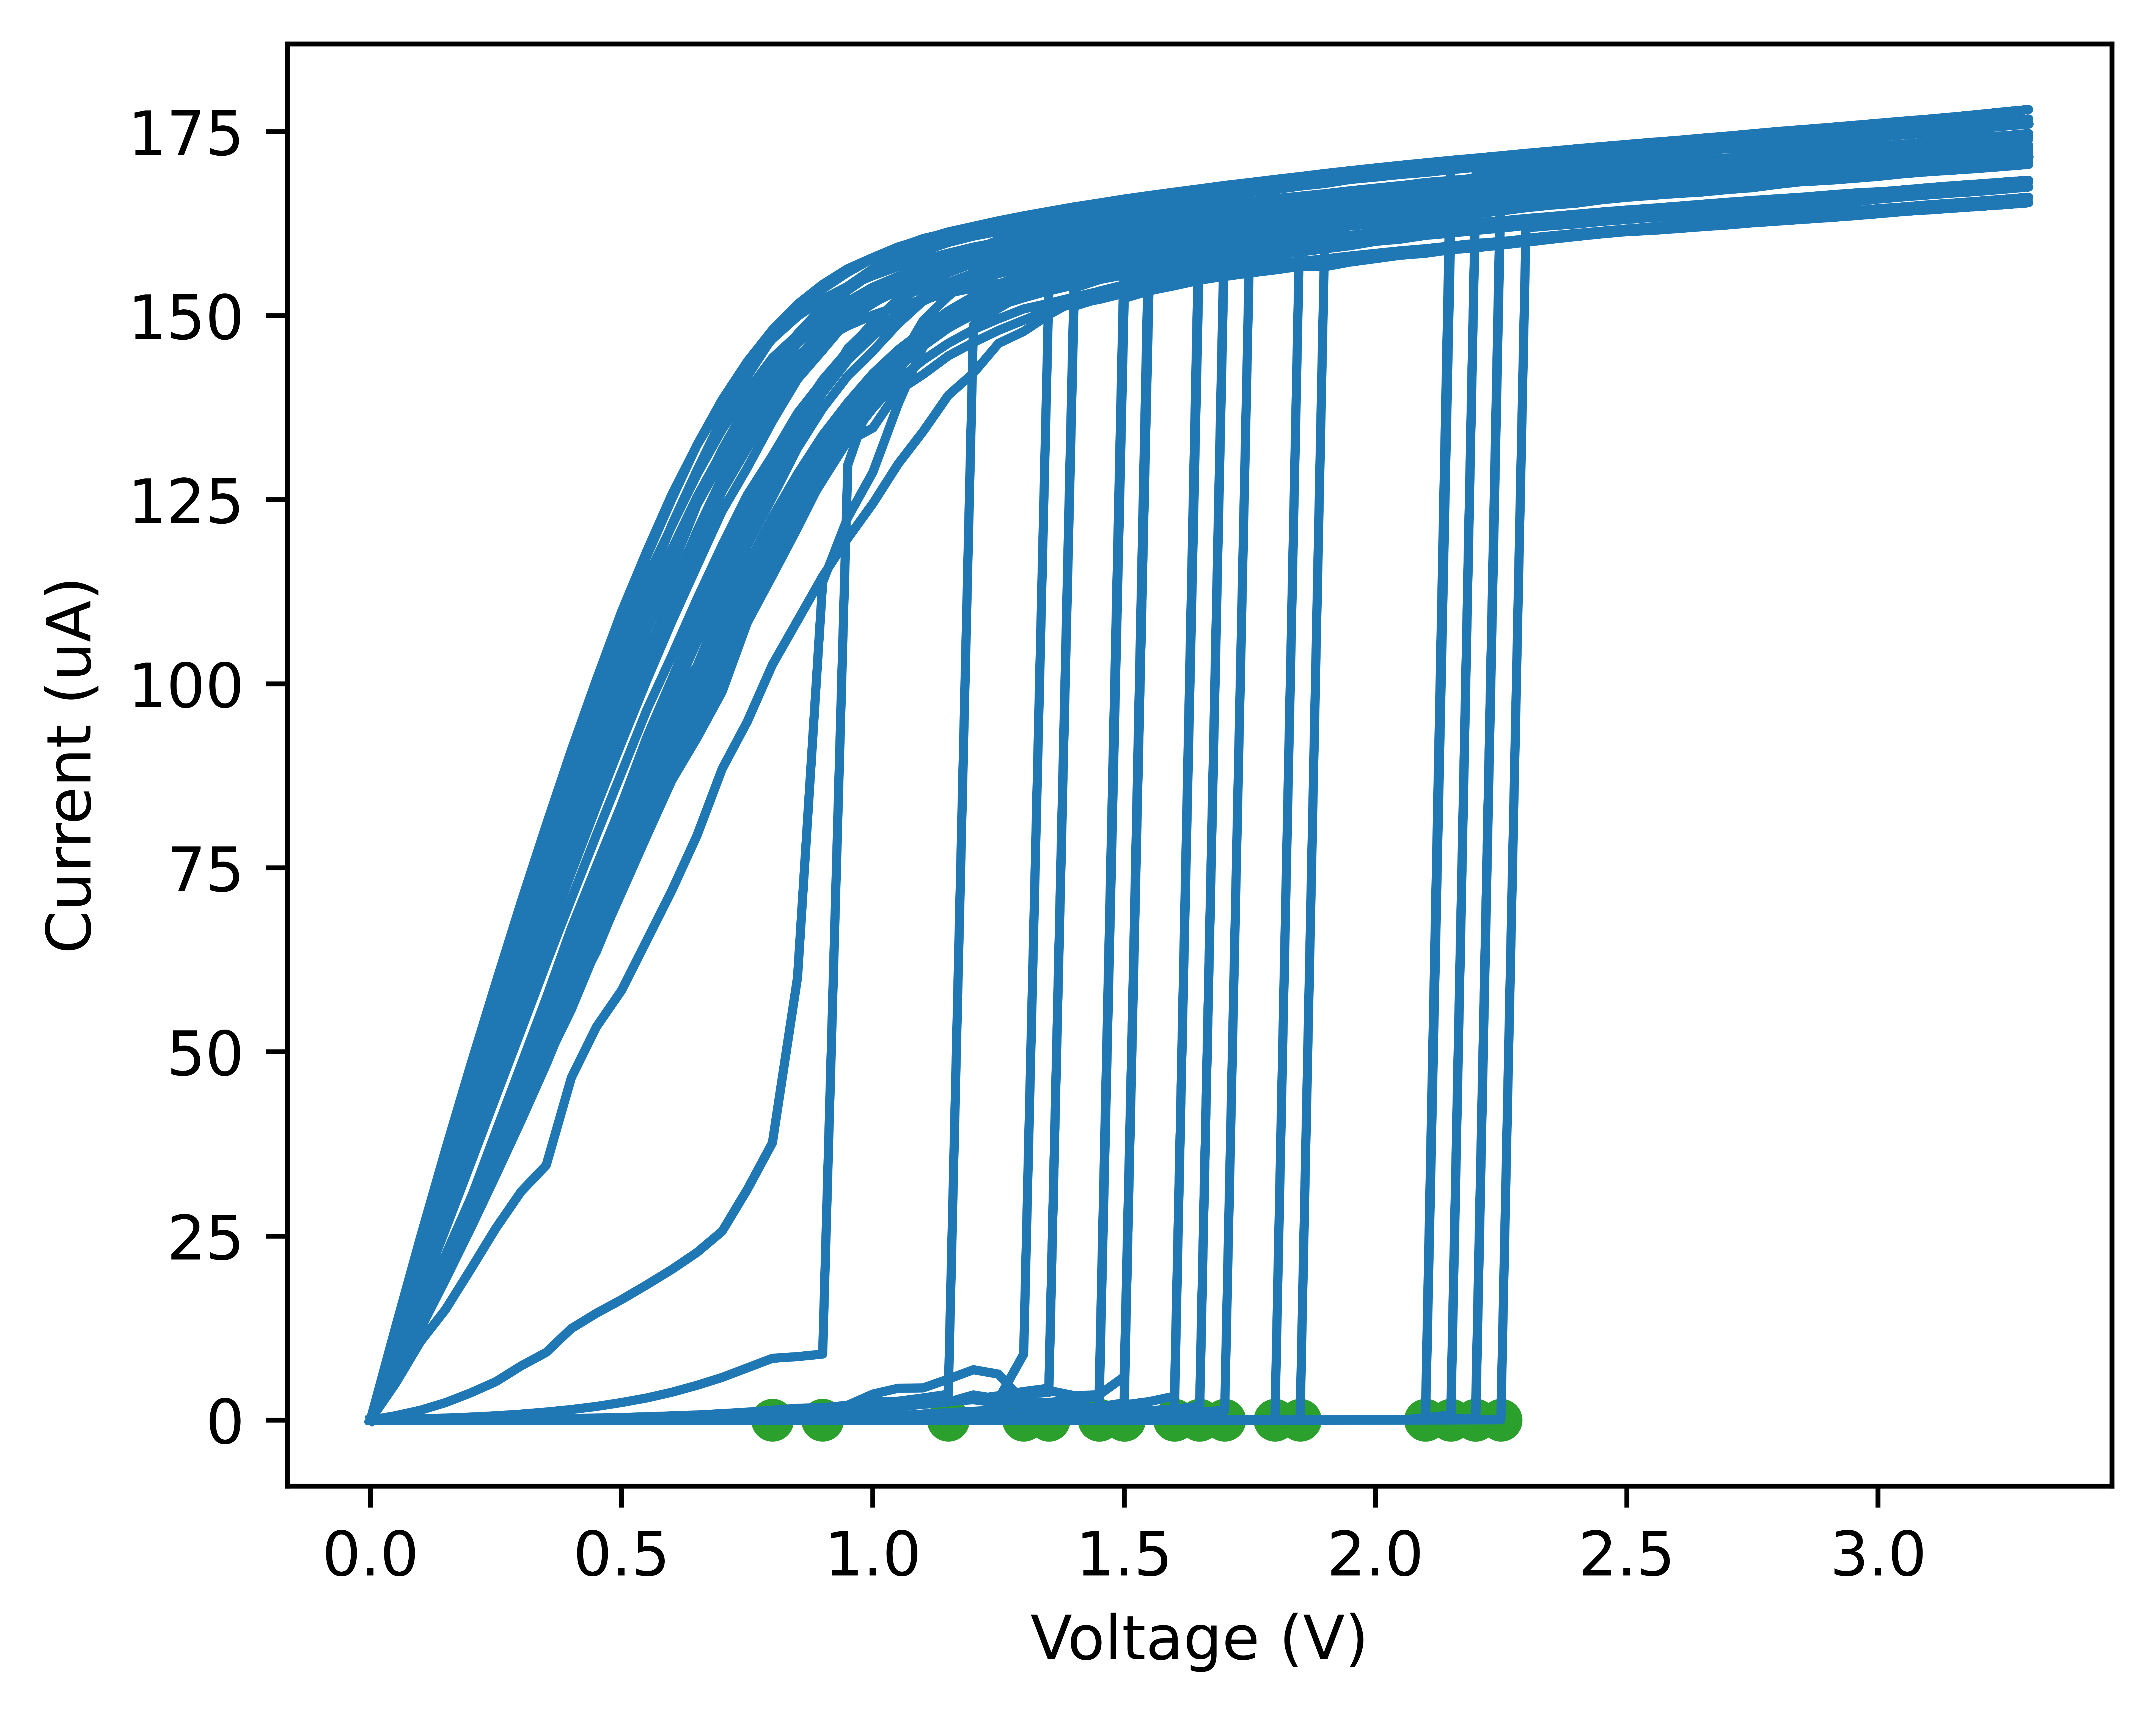

In [6]:
# analyze memristor as if it's a state machine
plot_iv = True
idx_to_ignore = [22, 14, 8] # I got this by looking at the iv plots for bad memristors

# 2D lists 
# the first dimension is devices
# the second is the LRS/HRS values of each i/v sweep
LRS = []
HRS = []

all_form_vs = [] #set voltages

read_v = 0.2 #voltage at which to 'read' LRS/HRS resitances
n_read_points = 8 # number of points to average  LRS/HRS

# threshold for determining when a form has occured
form_multiple_difference = 500

fig = plt.subplots(1,1,figsize=(5,4), dpi=1600)

for idx, d in enumerate(all_data['Form']):
    if idx == 6:
        continue
    if idx in idx_to_ignore:
        continue

    current = []
    voltage = []
    for j, p in enumerate(d[1]):

        current.append(p[1])
        voltage.append(p[0])

    curr_LRS = []
    curr_HRS = []

    sweeps_v = []
    sweeps_i = []
    sweeps_v.append([])
    sweeps_i.append([])

    state = 'check_form'
    form_vs = []
    form_is = []
    test_is = []
    test_vs = []
    HRS_measure_is = []
    HRS_measure_vs = []
    LRS_measure_is = []
    LRS_measure_vs = []
    read_resistances = []
    last_resistance = voltage[0]/current[0]
    last_v = voltage[0]
    last_i = current[0]
    last_x_is = []
    last_x_vs = []
    len_is = 8

    for v, i in zip(voltage, current):
        sweeps_i[-1].append(i)
        sweeps_v[-1].append(v)
        resistance = v/i
        # print(f'{state} {v} {min_vs} {read_resistances} {resistance} {last_resistance} {i} {min_is}')
        last_x_is.append(i)
        if len(last_x_is) > len_is:
            last_x_is.pop(0)
        last_x_vs.append(v)
        if len(last_x_vs) > len_is:
            last_x_vs.pop(0)

        if state=='check_form':
            if (len(last_x_is) == len_is and i > form_multiple_difference*np.mean(np.abs(last_x_is[0:4]))) or i > 0.00005:
                form_vs.append(last_v)
                form_is.append(last_i)
                test_is.append(last_x_is[0])
                test_vs.append(last_x_vs[0])
                last_5_is = []
                break
        
        last_resistance = resistance
        last_v = v
        last_i = i

    

    # add in the last one resistance level depending on what state we were last in
    if state=='read_hrs' and len(read_resistances) >0:
        curr_HRS.append(np.mean(read_resistances))
    elif state=='read_lrs' and len(read_resistances) >0:
        curr_LRS.append(np.mean(read_resistances))

    if plot_iv:


        idx_test = 0
        # plt.plot(sweeps_v[idx_test], 1/np.gradient(sweeps_i[idx_test]))
        # plt.plot(sweeps_v[idx_test], sweeps_i[idx_test], color='tab:blue')
        plt.plot(voltage, np.asarray(current)*1e6, color='tab:blue')
        plt.scatter(form_vs, form_is, color='tab:green')
        # plt.scatter(test_vs, test_is, color='tab:orange')
        # plt.scatter(HRS_measure_vs, HRS_measure_is, color='tab:purple')
        # plt.scatter(LRS_measure_vs, LRS_measure_is, color='k')
        # plt.title(f'{idx}')
        plt.ylabel('Current (uA)')
        plt.xlabel('Voltage (V)')
        # plt.yscale('log')
        # plt.show()

    # print(min_vs)
    all_form_vs.append(form_vs)
    LRS.append(np.asarray(curr_LRS))
    HRS.append(np.asarray(curr_HRS))
        

print(f'The Form Operation has been tested on {len(all_form_vs)} devices')
print(f'Form Voltage:\n\tmean: {np.mean(all_form_vs)} Volts\n\tstd: {np.std(all_form_vs)} Volts')

# print(np.std(HRS, axis=0))


